# Part 1: Preprocess Census Blocks

In [37]:
import sys

sys.path.insert(0, '..')
import geopandas
import maup
from read_config import read_yaml
import numpy as np

## Parse configuration

In [25]:
config = read_yaml('../preprocessing_config.yaml')
districts_geo_path = config['ARKANSAS']['DISTRICTS_GEO_PATH']
cb_geo_path = config['ARKANSAS']['CB_GEO_PATH']
cb_info_path = config['ARKANSAS']['CB_INFO_PATH']
precinct_election_path = config['ARKANSAS']['PRECINCTS_ELECTION_PATH']

## Load geometry and census data

In [26]:
districts_geo = geopandas.read_file(districts_geo_path)
cb_geo = geopandas.read_file(cb_geo_path)
cb_info = geopandas.read_file(cb_info_path)
precinct_election = geopandas.read_file(precinct_election_path)

## Process census block census data and merge with geometry

In [ ]:
cb_geo = cb_geo[['GEOID20', 'COUNTYFP20', 'geometry']]
cb_geo.rename(columns={'GEOID20': 'blockId', 'COUNTYFP20': 'fips'}, inplace=True)
cb_info = cb_info[['GEO_ID', 'P1_001N', 'P1_003N', 'P1_004N', 'P1_006N']]
cb_info.rename(
    columns={'GEO_ID': 'blockId', 'P1_001N': 'population', 'P1_003N': 'white', 'P1_004N': 'black', 'P1_006N': 'asian'},
    inplace=True)
cb_info = cb_info.iloc[1:]
cb_info['population'] = cb_info['population'].apply(int)
cb_info['white'] = cb_info['white'].apply(int)
cb_info['black'] = cb_info['black'].apply(int)
cb_info['asian'] = cb_info['asian'].apply(int)
cb_info['blockId'] = cb_info['blockId'].apply(lambda x: x.split('US')[1])
cb_geo['blockId'] = cb_geo['blockId'].apply(lambda col: str(col))
cb_info['blockId'] = cb_geo['blockId'].apply(lambda col: str(col))
cb = cb_geo.merge(cb_info, on='blockId')
print(cb.isna().sum())
print(len(cb))
assert (cb.isna().sum().sum() == 0), "imperfect matching in merging"

## Process district data

In [ ]:
districts_geo = districts_geo[['GEOID20', 'geometry']]
districts_geo.rename(columns={'GEOID20': 'districtId'}, inplace=True)
districts_geo['districtId'] = districts_geo['districtId'].apply(int)

## Assign census blocks to districts geographically

In [ ]:
assignment_cb_districts = maup.assign(cb, districts_geo)
assert (assignment_cb_districts.isna().sum() == 0), "Error in census block to district assignment"
cb['district'] = assignment_cb_districts
districts_geo['index'] = districts_geo.index
cb = cb.merge(districts_geo[['districtId', 'index']], left_on='district', right_on='index')
cb.drop(columns=['district', 'index'])
cb = cb[['blockId', 'districtId', 'fips', 'population', 'white', 'black', 'asian', 'geometry']]


## Fix geometry of precincts

In [ ]:
precinct_election.to_crs(cb_geo.crs, inplace=True)
precinct_election['geometry'] = precinct_election['geometry'].apply(lambda x: x.buffer(0))

## Assign census blocks to precincts and extract election data ratio

In [42]:
assignment_cb_precincts = maup.assign(cb, precinct_election)
cb['precinct'] = assignment_cb_precincts
precinct_election['index'] = precinct_election.index
cb = cb.merge(precinct_election[['G16PRERTRU', 'G16PREDCLI', 'index']], left_on='precinct', right_on='index').drop(
    columns=['precinct', 'index'])
cb.rename(columns={'G16PRERTRU': 'republican', 'G16PREDCLI': 'democrat'}, inplace=True)
cb['democrat'] = cb.apply(lambda x: x['democrat']/(x['democrat'] + x['republican'] + np.finfo(np.float32).eps),axis =1)
cb['republican'] = cb['democrat'].apply(lambda x: 1-x)

In [44]:
print(f'total population: {cb["population"].sum()}')
cb.head()

total population: 3011232


,blockId,precinctId,districtId,population,white,black,asian,democrat,republican,geometry
0,050510120011005,158,504,0,0,0,0,0.287043,0.712957,"POLYGON ((-93.00858 34.68780, -93.00845 34.687..."
1,050510120012061,158,504,1,1,0,0,0.287043,0.712957,"POLYGON ((-92.97957 34.69646, -92.97954 34.696..."
2,050510120022019,158,504,0,0,0,0,0.287043,0.712957,"POLYGON ((-93.00740 34.66767, -93.00696 34.667..."
3,050510120011017,158,504,86,23,0,1,0.287043,0.712957,"POLYGON ((-93.03460 34.67555, -93.03444 34.675..."
4,050510120022008,158,504,7,1,0,1,0.287043,0.712957,"POLYGON ((-93.01871 34.67349, -93.01870 34.673..."


## Visualize map colored by district

<AxesSubplot:>

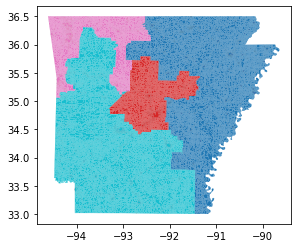

In [34]:
cb.plot('districtId')

## Visualize map colored by precinct

<AxesSubplot:>

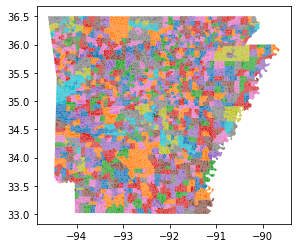

In [35]:
cb.plot('precinctId')

## Store in file system

In [ ]:
cb_path = config['ARKANSAS']['CB_PATH']
cb.to_file(cb_path, driver='GeoJSON')

# Part 2: Load into DB

In [41]:
cb_path = config['ARKANSAS']['CB_PATH']
cb = geopandas.read_file(cb_path)

## Transform into DB format

In [47]:
districtingId = str(config['ARKANSAS']['ENACTED_ID'])
cb['geometryId'] = cb['blockId'].apply(lambda x: str(int(x)))
cb['blockId'] = cb['blockId'].apply(lambda x: ''.join([districtingId, str(int(x))]))
cb['districtId'] = cb['districtId'].apply(lambda x: ''.join([districtingId, str(int(x))]))
cb['precinctId'] = cb['precinctId'].apply(lambda x: ''.join([districtingId, str(int(x))]))

## Add border block column

In [45]:
from processor import Processor

cb = Processor.compute_border_blocks(cb)

/Users/kostadindev/.conda/envs/preprocessing/lib/python3.9/site-packages/gerrychain/graph/adjacency.py:21: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometries[i].id = i
/Users/kostadindev/.conda/envs/preprocessing/lib/python3.9/site-packages/gerrychain/graph/graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [48]:
cb.head()

,blockId,precinctId,districtId,population,white,black,asian,democrat,republican,geometry,boundary,geometryId
0,650510120011005,6158,6504,0,0,0,0,0.287043,0.712957,"POLYGON ((-93.00858 34.68780, -93.00845 34.687...",0,50510120011005
1,650510120012061,6158,6504,1,1,0,0,0.287043,0.712957,"POLYGON ((-92.97957 34.69646, -92.97954 34.696...",0,50510120012061
2,650510120022019,6158,6504,0,0,0,0,0.287043,0.712957,"POLYGON ((-93.00740 34.66767, -93.00696 34.667...",0,50510120022019
3,650510120011017,6158,6504,86,23,0,1,0.287043,0.712957,"POLYGON ((-93.03460 34.67555, -93.03444 34.675...",0,50510120011017
4,650510120022008,6158,6504,7,1,0,1,0.287043,0.712957,"POLYGON ((-93.01871 34.67349, -93.01870 34.673...",0,50510120022008


<AxesSubplot:>

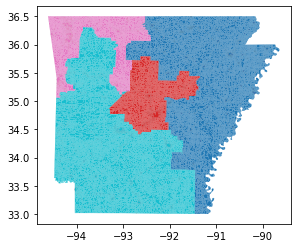

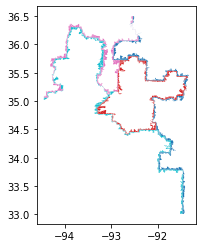

In [51]:
cb.plot('districtId')
cb[cb['boundary']== 1].plot('districtId')

## Set up DB connection

In [19]:
import mysql.connector

host = config['DATABASE']['HOST']
user = config['DATABASE']['USERNAME']
password = config['DATABASE']['PASSWORD']
database = config['DATABASE']['DB']
from db_connector import DBConnector

db = DBConnector(host, user, password, database)

## Populate

In [ ]:
db.populate_cb(cb)